#Support Vector Binary Classification of Disease State with Cycle Averaged Sensor Data
##Input Data: 15 sensor map of the cardiac cycle over a 1 second period ($15\times2000$)

##Investigation of:
* Classifier prediction performance.
* Out of sample prediction error.
* The effect of kernel choice: Linear, Polynomial, RBF.
* The effect of subsampling the time series. From 2000 down to $\sim$200 in steps.

**Daniel Wilson and John Mooney**

In [128]:
#Healthy defined as 0
#Unhealthy defined as 1

In [204]:
import mlpy.wavelet
import mcg
import numpy as np
import datetime
import timeit
import time
import copy
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import time
import gc
from matplotlib.mlab import PCA
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
from sklearn import svm
from sklearn import preprocessing
#matplotlib

mcg.deviceID = 'mk1'
mcg.setDeviceID()

#%matplotlib inline
from skimage.feature import match_template

mk1


#Load data

## 6060

In [205]:
path60  = '/home/john/Dropbox/Mubashir/6060DataFrame.pkl'
df60 = pd.read_pickle(path60)

#Randomly shuffle lst
df60 = df60.iloc[np.random.permutation(len(df60))]

X = df60['Coil Data'].values.tolist()

#checking to see if there are any floats, caused by the Nans, should still have 120
#X = lst['CoilData'].values.tolist()
for i, x in enumerate(X):
    #print i,type(x)
    if type(x)==float:
        
        print x
        index = []
        index.extend([i])
        #print index
        #X = np.delete(X,index)
print len(X)


#Cutting the readings down to 2000
for i, x in enumerate(X):
    #print 'a', X[i].shape
    X[i] = x.T[0:2000].T
    #print 'b', X[i].shape
    
#flattening X
for i, x in enumerate(X):
    X[i]= x.flatten()
    
#normalising the data, set 0 as mean value
X = preprocessing.scale(X) #CoilData

400


In [206]:
#creating a list of classes
le = preprocessing.LabelEncoder()

y = df60['Classification'].values.tolist()
le.fit(y)
y = le.transform(y)
print y.shape

(400,)


#SVC

In [77]:
import random
from sklearn.grid_search import GridSearchCV #optimizing gamma and c
from sklearn.grid_search import RandomizedSearchCV #optimizing gamma and c
from sklearn import cross_validation
from matplotlib.colors import Normalize
from sklearn.metrics import confusion_matrix

In [208]:
%matplotlib inline

In [209]:
#normalising the data, set 0 as mean value
val = X #preprocessing.scale(X) #CoilData

every=200
#print every
#X = val
subsampled=[]#copy.copy(val)
for i, x in enumerate(val):
    subsampled.append(x.T[::every].T)
    #subsampled[i]=(x.T[::every].T)
    
subsampled = np.asarray(subsampled)

# Exhaustive Gridsearch, visualising the fitness landscape

In [ ]:
clf = svm.SVC(kernel="rbf", probability = True, cache_size = 2000, class_weight = 'balanced')

gamma_range = np.linspace(0.09, 0.000001, 150)
c_range = np.linspace(0.1, 10, 50)
param_grid = dict(gamma = gamma_range, C = c_range)
#param_grid['kernel'] =['rbf']
#print param_grid

CV = cross_validation.StratifiedKFold(y, n_folds=5, shuffle = True)

grid = GridSearchCV(clf, param_grid, cv=CV, scoring="accuracy", n_jobs=6)
#grid = RandomizedSearchCV(clf, param_grid, cv=CV, scoring="accuracy", n_iter=10)

%time grid.fit(subsampled, y)

In [ ]:
plot_gridsearch(grid)

evaluate_gridsearch(subsampled, y, grid, CV)

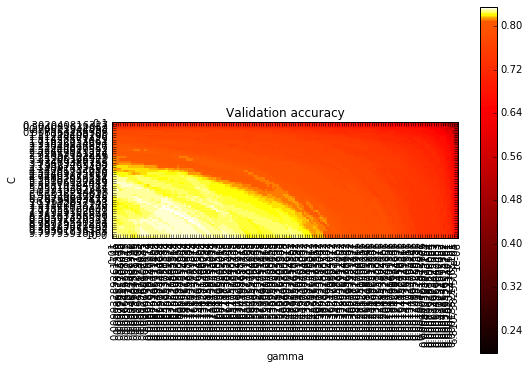

0.835
{'C': 7.3734693877551019, 'gamma': 0.0085236375838926171}
[ 0.85185185  0.8         0.85        0.9         0.7721519 ]
Accuracy: 0.83 (+/- 0.09)
sensitivity:  0.829268292683 spec:  0.875
sensitivity:  0.682926829268 spec:  0.923076923077
sensitivity:  0.878048780488 spec:  0.820512820513
sensitivity:  0.90243902439 spec:  0.897435897436
sensitivity:  0.775 spec:  0.769230769231
Mean sensitivity is 0.813536585366
Mean specificity is 0.857051282051
195 [105  90]


In [73]:
plot_gridsearch(grid)

evaluate_gridsearch(subsampled, y, grid, CV)

# Monte Carlo Search

### Search

In [ ]:
%time current, current_fitness, step_list = mcsearch(X, y, clf, CV, beta_min=1, beta_max=pow(10,3), n_iter=100, epsilon_C=5, epsilon_gamma=0.001,n_jobs=7, init_range=[1,0.005])

### Plot

In [ ]:
plot_optimser_performance(step_list)

# Tuning the MC parameters

In [ ]:
Here the 

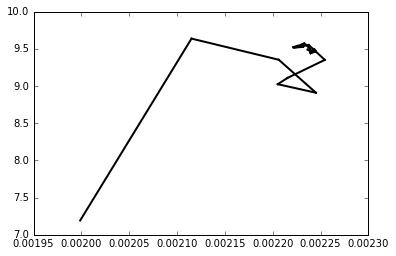

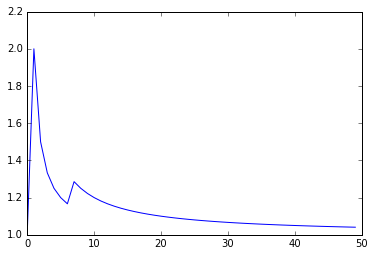

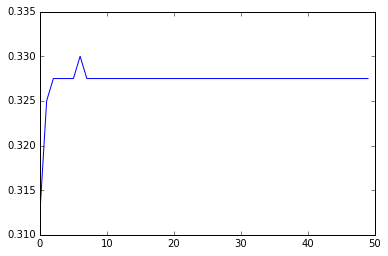

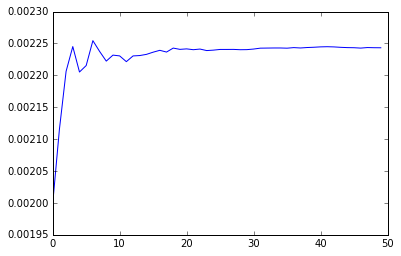

In [130]:
plot_traj(step_list)

frac_acc_list, C_list, gamma_list, fitness_list = mc_list(step_list)
fig=plt.figure()
plt.plot(frac_acc_list)
fig=plt.figure()
plt.plot(fitness_list)
fig=plt.figure()
plt.plot(gamma_list)

## MC functions

In [199]:
CV = cross_validation.StratifiedKFold(y, n_folds=5, shuffle = True)

def mcsearch(X, y, clf, CV, beta_min, beta_max, n_iter, epsilon_C, epsilon_gamma, n_jobs=4, init_range=[100,0.05]):
    ##initialise
    n_accepted = 1.0
    step_list=[]
    epsilon_C_min = 0.1
    epsilon_C_max = 10
    epsilon_gamma_min = 1e-7 
    epsilon_gamma_max = 0.01
    fraction_acc_ideal = 0.5
    fraction_acc = 0.0
    
    current = (random.uniform(0.1,init_range[0]), random.uniform(0, init_range[1]))
    clf.C = current[0]
    clf.gamma = current[1]
    fitness_current = 1 - cross_validation.cross_val_score(clf, X, y, cv=CV, n_jobs=n_jobs).mean()
    step_list.append({'step':1, 'C':current[0], 'gamma':current[1], 'fitness':fitness_current, 'frac_acc':1.0})
    #step_list = [{'step':0, 'C':current[0], 'gamma':current[1], 'fitness':fitness_current}]
    #Loop
    for step in range(2, n_iter):
        #beta = beta_min * pow(beta_max/beta_min,(float(step)-1)/(float(n_iter)-1))
        #beta = beta_min + beta_max*(float(step)-1)/(float(n_iter)-1)
        beta = beta_min + beta_max*pow((float(step)-1)/(float(n_iter)-1),2)
        
        scaling_factor = abs(fraction_acc - fraction_acc_ideal)
        if fraction_acc > fraction_acc_ideal:
            epsilon_C = epsilon_C/scaling_factor
            epsilon_gamma = epsilon_gamma/scaling_factor
        else:
            epsilon_C = epsilon_C*scaling_factor
            epsilon_gamma = epsilon_gamma*scaling_factor
        
        if epsilon_gamma < epsilon_gamma_min:
            epsilon_gamma = epsilon_gamma_min
        elif epsilon_gamma > epsilon_gamma_max:
            epsilon_gamma = epsilon_gamma_max
        if epsilon_C < epsilon_C_min:
            epsilon_C = epsilon_C_min
        elif epsilon_C > epsilon_C_max:
            epsilon_C = epsilon_C_max
        
        
        
        proposed = generateMove(current, epsilon_C, epsilon_gamma) 
        clf.C = proposed[0]
        clf.gamma = proposed[1]
        fitness_proposed = 1 - cross_validation.cross_val_score(clf, X, y, cv=CV, n_jobs=n_jobs).mean()
    
        #cost
        relative_fitness = fitness_proposed - fitness_current
        if relative_fitness < 0:
            current = proposed
            fitness_current = fitness_proposed
            n_accepted += 1
        elif np.log(random.random()) <= -1* beta * relative_fitness:
            current = proposed
            fitness_current = fitness_proposed
            n_accepted += 1
        
        
        fraction_acc = float(n_accepted)/float(step)
        if step <= 2:
            fraction_acc = 1
            
        print "n_acc, step, frac_acc ", n_accepted, step, fraction_acc
        
        

        
        step_stats = {'step':step, 'C':current[0], 'gamma':current[1], 
                          'fitness':fitness_current, 'frac_acc':fraction_acc, 
                          'epsilon_C':epsilon_C, 'epsilon_gamma':epsilon_gamma,
                         'beta':beta}
        step_list.append(step_stats)
        print step_stats
     
    return current, fitness_current, step_list
    

def generateMove(current, epsilon_C, epsilon_gamma):
    C = abs(random.gauss(current[0], epsilon_C))
    gamma = abs(random.gauss(current[1], epsilon_gamma))
    return (C, gamma)

In [200]:
def plot_traj(step_list):
    fig=plt.figure()

    C_p = step_list[0]['C']
    gamma_p = step_list[0]['gamma']
    plt.plot(gamma_p, C_p, 'bo')

    for step_dict in step_list:
        C = step_dict['C']
        gamma = step_dict['gamma']
        #print C, gamma

        plt.plot([gamma_p, gamma],[C_p, C], 'k-', lw=2)

        C_p = C
        gamma_p = gamma

    plt.plot(gamma_p, C_p, 'ro') 
    
def mc_list(step_list):

    frac_acc_list = []
    C_list = []
    gamma_list = []
    fitness_list = []
    epsilon_C_list = [] 
    epsilon_gamma_list = []

    for step_dict in step_list[1:]:
        frac_acc_list.append(step_dict['frac_acc'])
        fitness_list.append(step_dict['fitness'])
        C_list.append(step_dict['C'])
        gamma_list.append(step_dict['gamma'])
        epsilon_C_list.append(step_dict['epsilon_C'])
        epsilon_gamma_list.append(step_dict['epsilon_gamma'])
        
    return frac_acc_list, C_list, gamma_list, fitness_list, epsilon_C_list, epsilon_gamma_list
    
def plot_optimser_performance(step_list):
    plot_traj(step_list)
    
    frac_acc_list, C_list, gamma_list, fitness_list, epsilon_C_list, epsilon_gamma_list = mc_list(step_list)
    fig=plt.figure()
    plt.suptitle('fraction of accepted steps')
    plt.plot(frac_acc_list)
    fig=plt.figure()
    plt.suptitle('fitness')
    plt.plot(fitness_list)
    
    fig=plt.figure()
    plt.suptitle('epsilon_gamma')
    plt.plot(epsilon_gamma_list)
    
    fig=plt.figure()
    plt.suptitle('gamma')
    plt.plot(gamma_list)
    
    fig=plt.figure()
    plt.suptitle('epsilon_C')
    plt.plot(epsilon_C_list)
    fig=plt.figure()
    plt.suptitle('C')
    plt.plot(C_list)
    
    plot_tempcurve(beta_min, beta_max, n_iter)
    
def plot_tempcurve(beta_min, beta_max, n_iter):
    beta_list=[]

    for step in range(2, n_iter):
        #beta = beta_min * pow(beta_max/beta_min,(float(step)-1)/(float(n_iter)-1))
        #beta = beta_min + beta_max*(float(step)-1)/(float(n_iter)-1)
        beta = beta_min + beta_max*pow((float(step)-1)/(float(n_iter)-1),2)
        beta_list.append(beta)
        #print beta
    fig=plt.figure()
    plt.suptitle("Temperature Curve")
    plt.plot(beta_list)
    

In [201]:
%time current, current_fitness, step_list = mcsearch(X, y, clf, CV, beta_min=1, beta_max=pow(10,4), n_iter=100, epsilon_C=5, epsilon_gamma=0.001,n_jobs=7, init_range=[1,0.005])

n_acc, step, frac_acc  2.0 2 1
{'beta': 2.020304050607081, 'epsilon_gamma': 0.0005, 'step': 2, 'frac_acc': 1, 'fitness': 0.42249492108141895, 'C': 4.456763363247443, 'gamma': 0.00413557467188893, 'epsilon_C': 2.5}
n_acc, step, frac_acc  3.0 3 1.0
{'beta': 5.081216202428324, 'epsilon_gamma': 0.001, 'step': 3, 'frac_acc': 1.0, 'fitness': 0.38243006719799966, 'C': 12.217262849732657, 'gamma': 0.0031726468700293865, 'epsilon_C': 5.0}
n_acc, step, frac_acc  4.0 4 1.0
{'beta': 10.18273645546373, 'epsilon_gamma': 0.002, 'step': 4, 'frac_acc': 1.0, 'fitness': 0.1574175652445694, 'C': 29.6854892899606, 'gamma': 0.0006604451039544197, 'epsilon_C': 10.0}
n_acc, step, frac_acc  4.0 5 0.8
{'beta': 17.324864809713297, 'epsilon_gamma': 0.004, 'step': 5, 'frac_acc': 0.8, 'fitness': 0.1574175652445694, 'C': 29.6854892899606, 'gamma': 0.0006604451039544197, 'epsilon_C': 10}
n_acc, step, frac_acc  4.0 6 0.666666666667
{'beta': 26.507601265177023, 'epsilon_gamma': 0.01, 'step': 6, 'frac_acc': 0.6666666666

KeyboardInterrupt: 

In [195]:
%time current, current_fitness, step_list = mcsearch(X, y, clf, CV, beta_min=1, beta_max=pow(10,4), n_iter=100, epsilon_C=5, epsilon_gamma=0.001,n_jobs=7, init_range=[1,0.005])

n_acc, step, frac_acc  2.0 2 1
{'epsilon_gamma': 0.0005, 'C': 4.065019138408761, 'frac_acc': 1, 'step': 2, 'epsilon_C': 5.0, 'fitness': 0.36499999999999999, 'gamma': 0.0018986395615695005}
n_acc, step, frac_acc  2.0 3 0.666666666667
{'epsilon_gamma': 0.001, 'C': 4.065019138408761, 'frac_acc': 0.6666666666666666, 'step': 3, 'epsilon_C': 10.0, 'fitness': 0.36499999999999999, 'gamma': 0.0018986395615695005}
n_acc, step, frac_acc  3.0 4 0.75
{'epsilon_gamma': 0.006000000000000002, 'C': 14.320043603352119, 'frac_acc': 0.75, 'step': 4, 'epsilon_C': 20, 'fitness': 0.21499999999999997, 'gamma': 0.0006343964339899134}
n_acc, step, frac_acc  3.0 5 0.6
{'epsilon_gamma': 0.01, 'C': 14.320043603352119, 'frac_acc': 0.6, 'step': 5, 'epsilon_C': 20, 'fitness': 0.21499999999999997, 'gamma': 0.0006343964339899134}
n_acc, step, frac_acc  3.0 6 0.5
{'epsilon_gamma': 0.01, 'C': 14.320043603352119, 'frac_acc': 0.5, 'step': 6, 'epsilon_C': 20, 'fitness': 0.21499999999999997, 'gamma': 0.0006343964339899134}
n

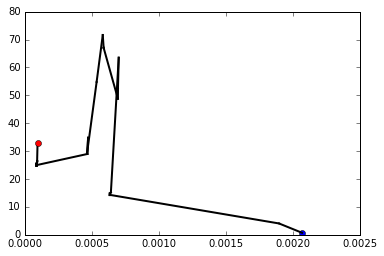

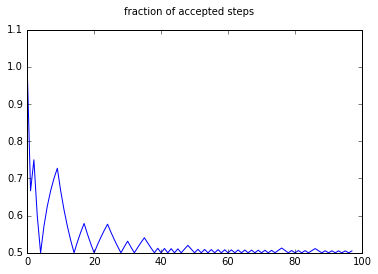

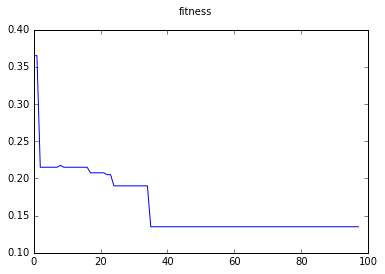

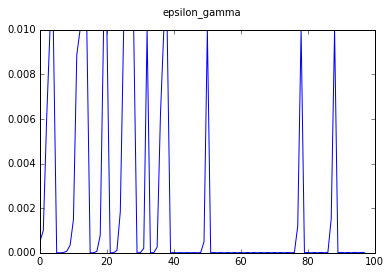

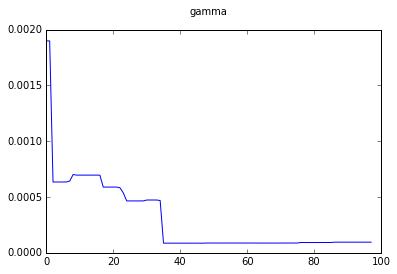

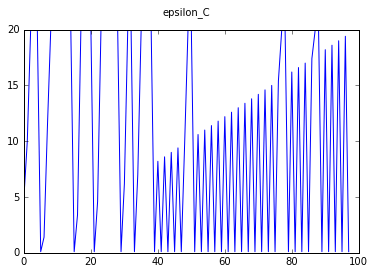

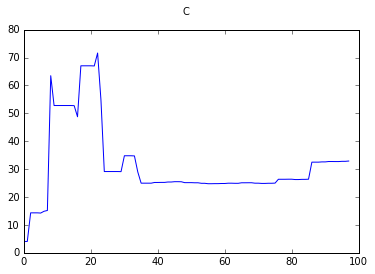

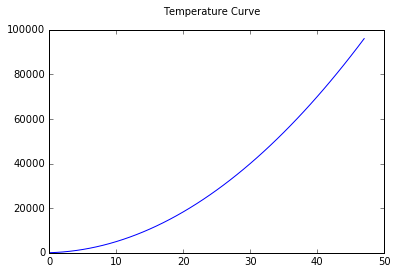

In [197]:
plot_optimser_performance(step_list)
#beta_min=1, beta_max=pow(10,4), n_iter=100, epsilon_C=10, epsilon_gamma=0.001,n_jobs=7, init_range=[1,0.005]

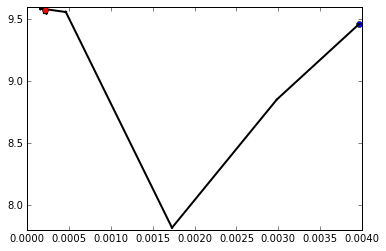

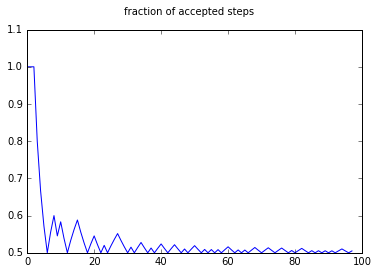

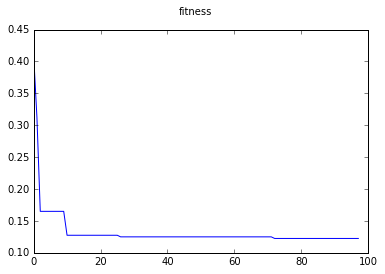

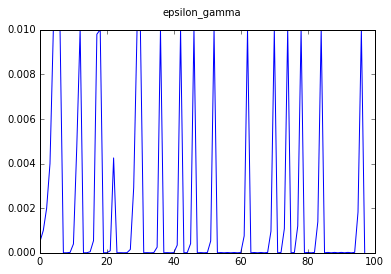

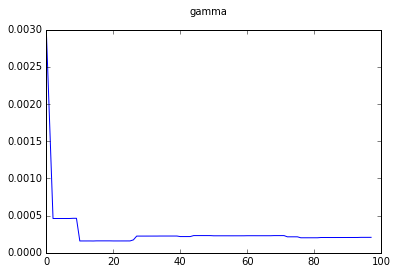

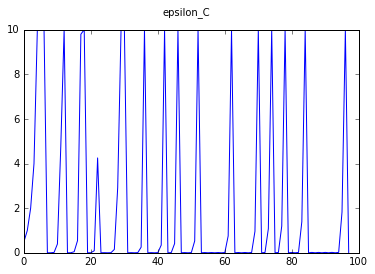

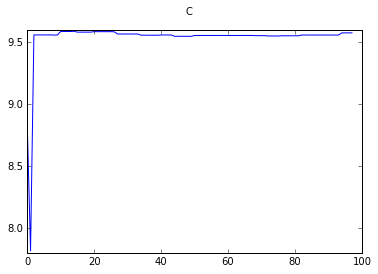

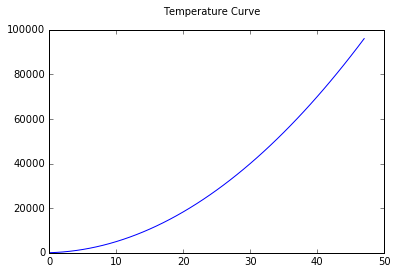

In [191]:
plot_optimser_performance(step_list)
#beta_min=1, beta_max=pow(10,5), n_iter=100, epsilon_C=40, epsilon_gamma=0.001,n_jobs=7, init_range=[20,0.005]

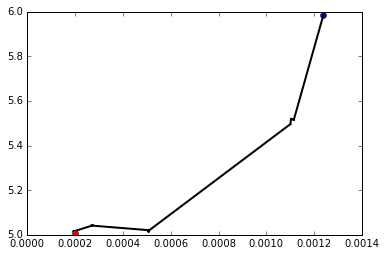

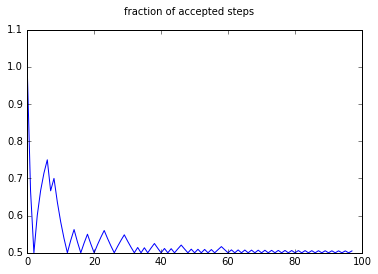

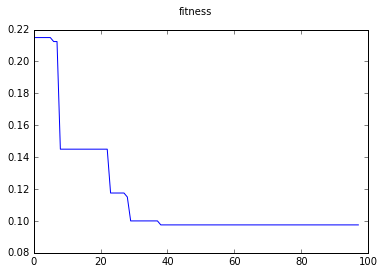

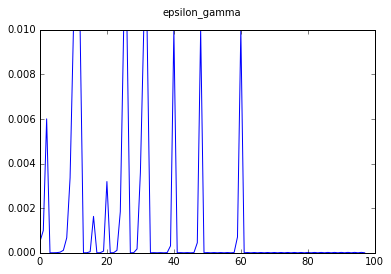

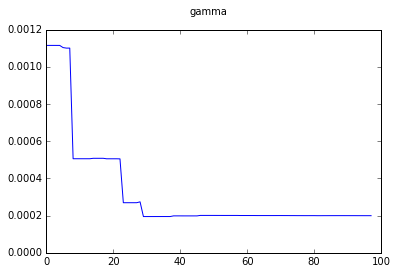

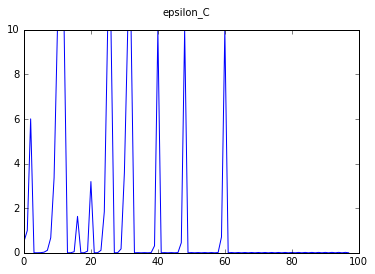

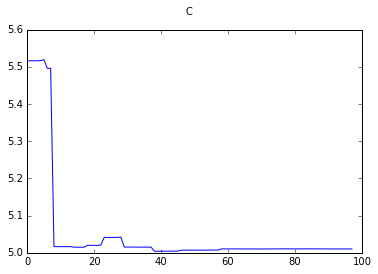

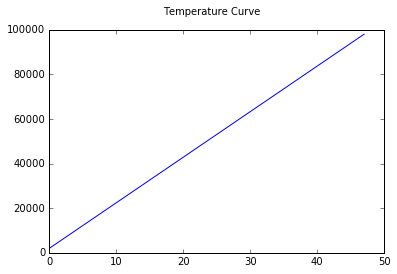

In [187]:
plot_optimser_performance(step_list)

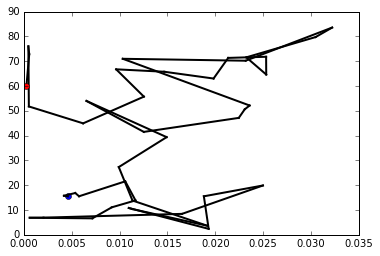

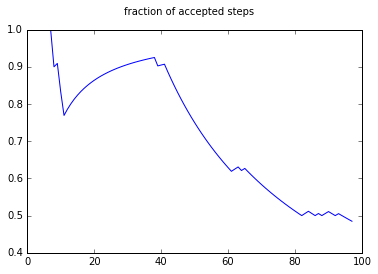

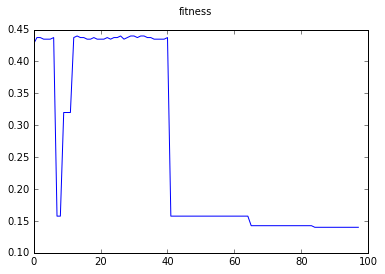

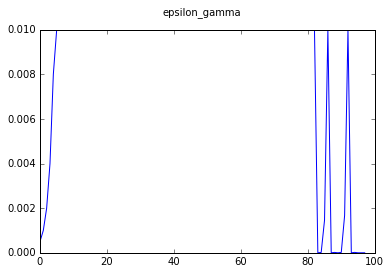

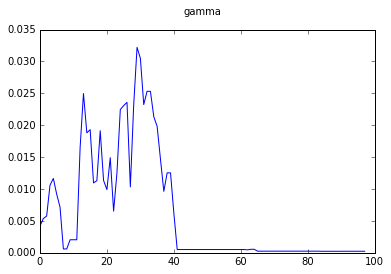

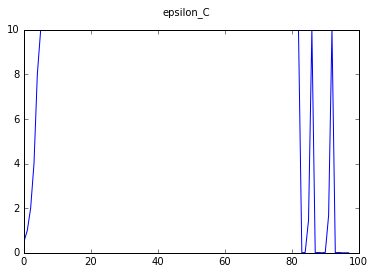

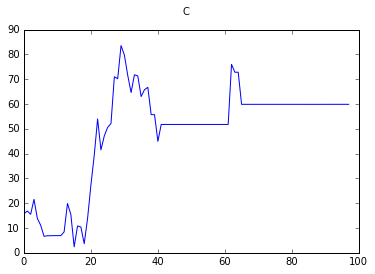

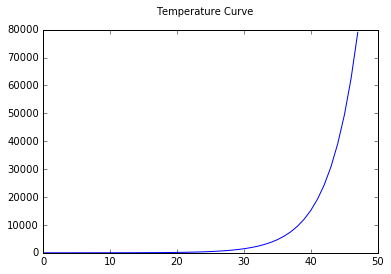

In [175]:
plot_optimser_performance(step_list)

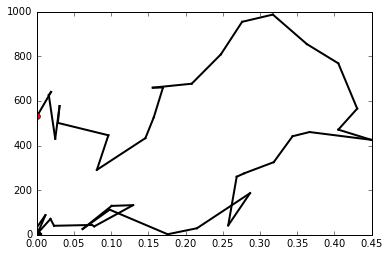

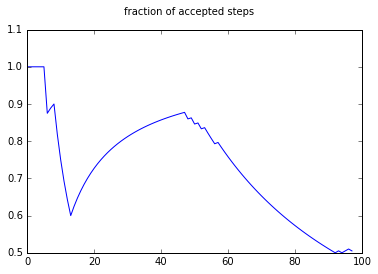

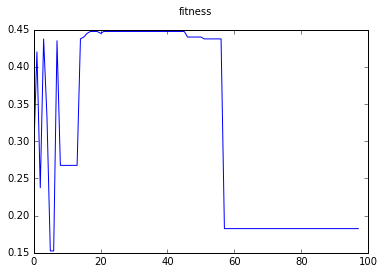

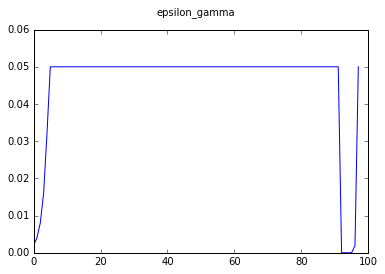

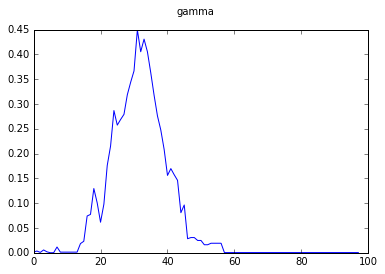

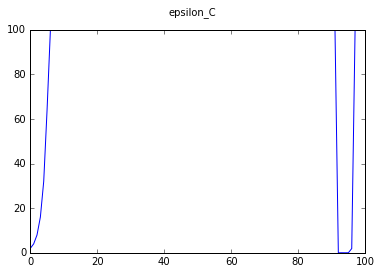

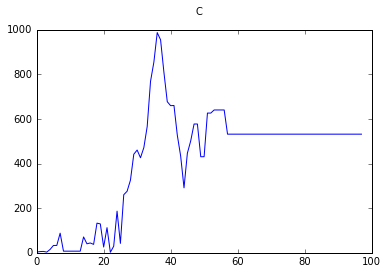

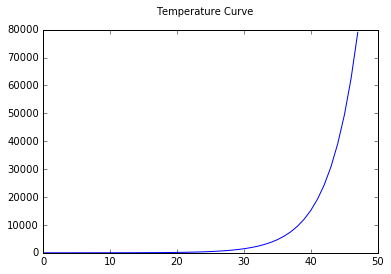

In [172]:
plot_optimser_performance(step_list)

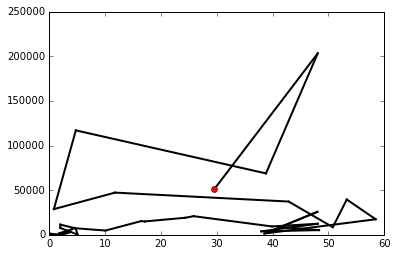

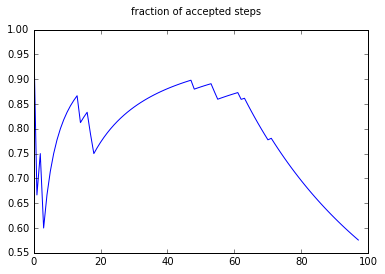

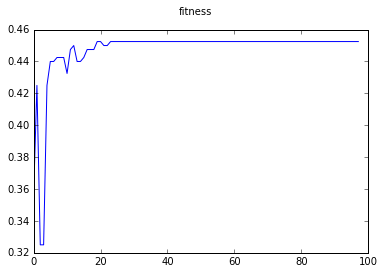

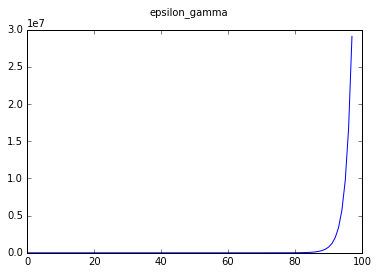

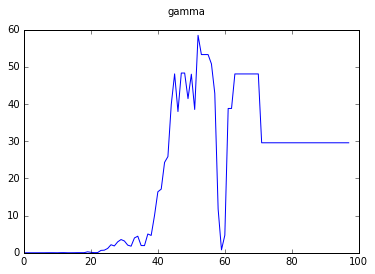

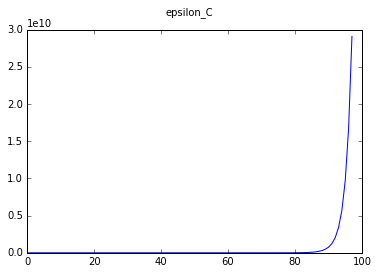

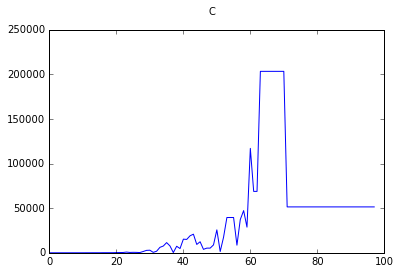

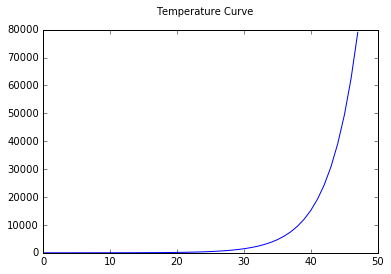

In [166]:
plot_optimser_performance(step_list)

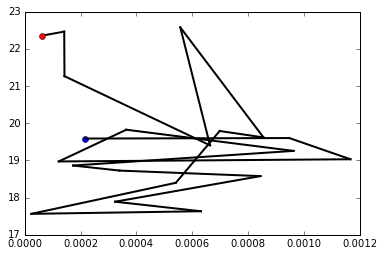

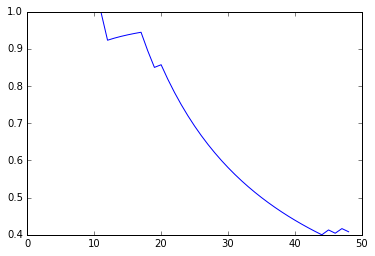

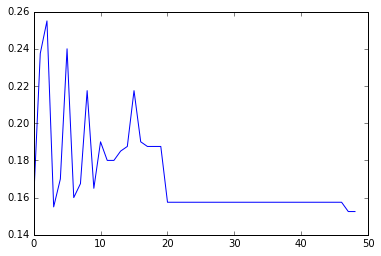

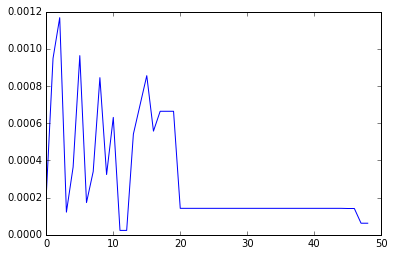

In [149]:
plot_traj(step_list)


frac_acc_list, C_list, gamma_list, fitness_list = mc_list(step_list)
fig=plt.figure()
plt.title = ()
plt.plot(frac_acc_list)
fig=plt.figure()
plt.plot(fitness_list)
fig=plt.figure()
plt.plot(gamma_list)

In [60]:
def plot_gridsearch(grid):
    scores = [x[1] for x in grid.grid_scores_]
    scores = np.array(scores).reshape(len(c_range), len(gamma_range))

    np.save('gridsearchscores_full.npy', scores)

    class MidpointNormalize(Normalize):

        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y))


    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.81))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=90)
    plt.yticks(np.arange(len(c_range)), c_range)
    plt.title('Validation accuracy')
    plt.show()



def evaluate_gridsearch(val, y, grid, CV):
    print grid.best_score_
    print grid.best_params_
    #print grid.grid_scores_[79][1]
    #optimum clf here,with the best params

    clf = svm.SVC(kernel="rbf" , probability = True, cache_size = 1200, class_weight = "balanced" ,
                  C = grid.best_params_['C'], gamma = grid.best_params_['gamma'])

    #nested cross validation score
    CVS = cross_validation.cross_val_score
    scores = CVS(clf, val, y, cv=CV, n_jobs = 1)
    print scores

    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    #this tells us how well its actualy performing, due to the unbalanced data

    
    sen_list = []
    spec_list = []


    for i, (train, test) in enumerate(CV):
        y_pred = clf.fit(val[train], y[train]).predict(val[test])
        #print y_pred,"predicted"
        #print y[test], "actual"
        cm = confusion_matrix(y[test], y_pred)

        tn = float(cm[0][0])/np.sum(cm[0])
        tp = float(cm[1][1])/np.sum(cm[1])
        print "sensitivity: ", tn, "spec: ", tp
        sen_list.append(tn)
        spec_list.append(tp)

    mean_sen = sum(sen_list)/float(len(sen_list))
    mean_spec = sum(spec_list)/float(len(sen_list))
    print "Mean sensitivity is", mean_sen
    print "Mean specificity is", mean_spec

    SV = clf.n_support_
    print sum(SV),SV
    
    return accuracy, err, mean_sen, mean_spec, sen_list, spec_list, SV